## DATA 620

---
### Project 1
### Mael Illien and Jeremy OBrien

Reference materials:
- [Foursquare Endpoints Overview](https://developer.foursquare.com/docs/places-api/endpoints/)
- [Foursquare Places API Next Venues](https://developer.foursquare.com/docs/api-reference/venues/nextvenues/)
- [Foursquare Places API Venue Categories](https://developer.foursquare.com/docs/api-reference/venues/categories/)
- [Foursquare Places API Authentication](https://developer.foursquare.com/docs/places-api/authentication/)
- [Building a Foursquare Location Graph](https://nbviewer.jupyter.org/github/furukama/IPythonNotebooks/blob/master/Building%20a%20Foursquare%20Location%20Graph.ipynb)
- [How to create a location graph from the Foursquare API](http://beautifuldata.net/2014/05/how-to-create-a-location-graph-from-the-foursquare-api/)
- [Classification of Moscow Metro stations using Foursquare data](https://towardsdatascience.com/classification-of-moscow-metro-stations-using-foursquare-data-fb8aad3e0e4)
- [A brief guide to using Foursquare API with a hands-on example in Python](https://medium.com/@aboutiana/a-brief-guide-to-using-foursquare-api-with-a-hands-on-example-on-python-6fc4d5451203)

Bounding box for NYC based on [geographic extent](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/nybb_metadata.pdf?ver=18c)
- North 40.915568 
- South 40.495992
- East -73.699215
- West -74.257159 

In [1]:
# We can alternatively use the venue attribute City
bbox = [40.4959929,-74.257159,40.915568,-73.699215]  # bounding box for New York City

In [2]:
import foursquare
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from config import foursquare_config as fs_config

In [3]:
new_crawl = []  # list of locations to be crawled
done_crawl = []  # list of crawled locations 
links = []  # list of tuples that represent links between locations
venues = pd.DataFrame(columns=['id','name','type','lat','lng'])  # dataframe (not dict?) of location id => meta-data on location 

In [4]:
# Fill these out to run but don't save to Github
CLIENT_ID = fs_config['id']
CLIENT_SECRET = fs_config['secret']

client = foursquare.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

In [5]:
# Root
#venue = client.venues('43695300f964a5208c291fe3')
venue = client.venues('40abf500f964a52035f31ee3')  # Washington Square Park
venue['venue']

{'id': '40abf500f964a52035f31ee3',
 'name': 'Washington Square Park',
 'contact': {'twitter': 'nycparks',
  'facebook': '104475634308',
  'facebookUsername': 'BartowPell',
  'facebookName': 'Bartow-Pell Mansion Museum'},
 'location': {'address': 'W 4th St',
  'crossStreet': 'btwn MacDougal St & University Pl',
  'lat': 40.73081579656163,
  'lng': -73.9974582195282,
  'labeledLatLngs': [{'label': 'display',
    'lat': 40.73081579656163,
    'lng': -73.9974582195282}],
  'postalCode': '10012',
  'cc': 'US',
  'city': 'New York',
  'state': 'NY',
  'country': 'United States',
  'formattedAddress': ['W 4th St (btwn MacDougal St & University Pl)',
   'New York, NY 10012',
   'United States']},
 'canonicalUrl': 'https://foursquare.com/v/washington-square-park/40abf500f964a52035f31ee3',
 'categories': [{'id': '4bf58dd8d48988d163941735',
   'name': 'Park',
   'pluralName': 'Parks',
   'shortName': 'Park',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
    

In [6]:
# Example atrribute extracted from a next venue
nv = client.venues.nextvenues('43695300f964a5208c291fe3')['nextVenues']['items']
nv[0]['categories'][0]['shortName']

'Scenic Lookout'

In [7]:
client.venues.nextvenues('43695300f964a5208c291fe3')

{'nextVenues': {'count': 5,
  'items': [{'id': '4bcca12bb6c49c7422169491',
    'name': '86th Floor Observation Deck',
    'location': {'address': '350 5th Ave',
     'crossStreet': 'btwn 33rd & 34th Sts',
     'lat': 40.74844544481811,
     'lng': -73.98568124187432,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.74844544481811,
       'lng': -73.98568124187432}],
     'postalCode': '10118',
     'cc': 'US',
     'city': 'New York',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['350 5th Ave (btwn 33rd & 34th Sts)',
      'New York, NY 10118',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d165941735',
      'name': 'Scenic Lookout',
      'pluralName': 'Scenic Lookouts',
      'shortName': 'Scenic Lookout',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/sceniclookout_',
       'suffix': '.png'},
      'primary': True}],
    'venuePage': {'id': '64514350'}},
   {'id': '49b7ed6df964a520305

In [8]:
def is_in_NYC(lat, long):
    print((lat > bbox[0]) & (lat < bbox[2]) & (long > bbox[1]) & (long < bbox[3]))
    return (lat > bbox[0]) & (lat < bbox[2]) & (long > bbox[1]) & (long < bbox[3])

In [9]:
def extract_venue_data(venue):
    #print(venue)
    
    data = {'id': [venue['venue']['id']],
            'name': [venue['venue']['name']],
            'type': [venue['venue']['categories'][0]['shortName']],
            'lat': [venue['venue']['location']['lat']],
            'lng': [venue['venue']['location']['lng']]}
    return data
    

In [25]:
#to_crawl = ['43695300f964a5208c291fe3']  # Example of the Empire State Building
to_crawl = ['40abf500f964a52035f31ee3']  # Washington Square Park
depth = 8

In [26]:
for i in range(depth):

    new_crawl = []
    print('Step {}: {} locations and {} links. {} venues to go.'.format(i,len(venues),len(links), len(to_crawl)))
    for v in to_crawl:
        # Only add extract and add data for new venue ids
        if v not in venues['id']:
            ven = client.venues(v)
            data = extract_venue_data(ven)
            venues = venues.append(pd.DataFrame(data))
            
            print(venues)
            
        # Add next venues that are in NYC but have not yet been visited   
            next_venues = client.venues.nextvenues(v)['nextVenues']['items']
        for nv in next_venues:
            
            print(nv['id'])
            lat = nv['location']['lat']
            long = nv['location']['lng']
            print(lat, long)
            if is_in_NYC(lat, long):
                print('in NYC')
                print(venues['id'])
                if nv['id'] not in venues['id']:
                    print(nv['id'])
                    data = extract_venue_data(client.venues(nv['id']))
                    venues = venues.append(pd.DataFrame(data))
                
                if (nv['id'] not in done_crawl) & (nv['id'] not in to_crawl) & (nv['id'] not in new_crawl):
                    print('new crawl')
                    new_crawl.append(nv['id'])
                links.append((v, nv['id']))
        done_crawl.append(v)
    to_crawl = new_crawl
                

Step 0: 25 locations and 40 links. 1 venues to go.


Unknown error. meta: {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5eebab33882fc7001b81f52b'}
Unknown error. meta: {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5eebac08b1cac0001bf02192'}
Unknown error. meta: {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5eebac6c9da7ee001b2e1132'}


FoursquareException: Unknown error. meta: {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5eebac6c9da7ee001b2e1132'}

In [12]:
links

[('40abf500f964a52035f31ee3', '3fd66200f964a520def11ee3'),
 ('40abf500f964a52035f31ee3', '4caf3aa3b4b0a35db3273fce'),
 ('40abf500f964a52035f31ee3', '44dc96e4f964a520b0361fe3'),
 ('40abf500f964a52035f31ee3', '4af281eaf964a520d2e721e3'),
 ('40abf500f964a52035f31ee3', '40f1d480f964a5206a0a1fe3'),
 ('3fd66200f964a520def11ee3', '43fe1ba4f964a520f82f1fe3'),
 ('3fd66200f964a520def11ee3', '43bba61df964a520eb2c1fe3'),
 ('3fd66200f964a520def11ee3', '40abf500f964a52035f31ee3'),
 ('3fd66200f964a520def11ee3', '4a8cc1d4f964a520130f20e3'),
 ('3fd66200f964a520def11ee3', '49c27575f964a520f1551fe3'),
 ('4caf3aa3b4b0a35db3273fce', '40abf500f964a52035f31ee3'),
 ('4caf3aa3b4b0a35db3273fce', '3fd66200f964a520def11ee3'),
 ('4caf3aa3b4b0a35db3273fce', '4e0a497bc65b62ba40da54ca'),
 ('4caf3aa3b4b0a35db3273fce', '3fd66200f964a5202ee61ee3'),
 ('4caf3aa3b4b0a35db3273fce', '43768200f964a520472a1fe3'),
 ('44dc96e4f964a520b0361fe3', '40abf500f964a52035f31ee3'),
 ('44dc96e4f964a520b0361fe3', '4691e9b3f964a520c2481fe3'

In [24]:
import csv
with open('westvil_links.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(links)

In [13]:
venues

,id,name,type,lat,lng
0,40abf500f964a52035f31ee3,Washington Square Park,Park,40.730816,-73.997458
0,3fd66200f964a520def11ee3,Union Square Park,Park,40.735323,-73.990243
0,4caf3aa3b4b0a35db3273fce,Washington Square Fountain,Fountain,40.730818,-73.997459
0,44dc96e4f964a520b0361fe3,Think Coffee,Coffee Shop,40.728305,-73.995510
0,4af281eaf964a520d2e721e3,Starbucks,Coffee Shop,40.729655,-73.996179
0,40f1d480f964a5206a0a1fe3,High Line,Park,40.746825,-74.005507
0,3fd66200f964a520def11ee3,Union Square Park,Park,40.735323,-73.990243
0,43fe1ba4f964a520f82f1fe3,Barnes & Noble,Bookstore,40.736909,-73.989653
0,43bba61df964a520eb2c1fe3,Whole Foods Market,Grocery Store,40.735045,-73.991101
0,40abf500f964a52035f31ee3,Washington Square Park,Park,40.730816,-73.997458


In [14]:
venues.to_csv('venues_westvil.csv', index=False)

In [15]:
venues.drop_duplicates()

,id,name,type,lat,lng
0,40abf500f964a52035f31ee3,Washington Square Park,Park,40.730816,-73.997458
0,3fd66200f964a520def11ee3,Union Square Park,Park,40.735323,-73.990243
0,4caf3aa3b4b0a35db3273fce,Washington Square Fountain,Fountain,40.730818,-73.997459
0,44dc96e4f964a520b0361fe3,Think Coffee,Coffee Shop,40.728305,-73.995510
0,4af281eaf964a520d2e721e3,Starbucks,Coffee Shop,40.729655,-73.996179
0,40f1d480f964a5206a0a1fe3,High Line,Park,40.746825,-74.005507
0,43fe1ba4f964a520f82f1fe3,Barnes & Noble,Bookstore,40.736909,-73.989653
0,43bba61df964a520eb2c1fe3,Whole Foods Market,Grocery Store,40.735045,-73.991101
0,4a8cc1d4f964a520130f20e3,Strand Bookstore,Bookstore,40.733140,-73.990912
0,49c27575f964a520f1551fe3,Union Square Greenmarket,Farmer's Market,40.736536,-73.990484


In [16]:
venues.drop_duplicates().to_csv('venues_westvil_unique.csv', index=False)

In [17]:
# Generate network
venues = venues.drop_duplicates()
labels = dict(zip(list(venues['id']),list(venues['name'])))

G = nx.DiGraph()
G.add_nodes_from(venues['id'])
for f, t in links:
    G.add_edge(f, t)
    
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 25
Number of edges: 40
Average in degree:   1.6000
Average out degree:   1.6000


In [18]:
pagerank = nx.pagerank(G, alpha=.9)
venues['pagerank'] = [pagerank[n] for n in venues['id']]

betweenness = nx.betweenness_centrality(G)
venues['betweenness'] = [betweenness[n] for n in venues['id']]

venues

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,name,type,lat,lng,pagerank,betweenness
0,40abf500f964a52035f31ee3,Washington Square Park,Park,40.730816,-73.997458,0.074517,0.192029
0,3fd66200f964a520def11ee3,Union Square Park,Park,40.735323,-73.990243,0.069189,0.158514
0,4caf3aa3b4b0a35db3273fce,Washington Square Fountain,Fountain,40.730818,-73.997459,0.037050,0.038043
0,44dc96e4f964a520b0361fe3,Think Coffee,Coffee Shop,40.728305,-73.995510,0.052928,0.012681
0,4af281eaf964a520d2e721e3,Starbucks,Coffee Shop,40.729655,-73.996179,0.052928,0.012681
0,40f1d480f964a5206a0a1fe3,High Line,Park,40.746825,-74.005507,0.037050,0.072464
0,43fe1ba4f964a520f82f1fe3,Barnes & Noble,Bookstore,40.736909,-73.989653,0.036092,0.012681
0,43bba61df964a520eb2c1fe3,Whole Foods Market,Grocery Store,40.735045,-73.991101,0.052171,0.031703
0,4a8cc1d4f964a520130f20e3,Strand Bookstore,Bookstore,40.733140,-73.990912,0.042588,0.018116
0,49c27575f964a520f1551fe3,Union Square Greenmarket,Farmer's Market,40.736536,-73.990484,0.051979,0.000000


In [19]:
graph_pos = nx.spring_layout(G)
graph_pos

{'40abf500f964a52035f31ee3': array([-0.10689099,  0.09692466]),
 '3fd66200f964a520def11ee3': array([-0.25698233, -0.14930851]),
 '4caf3aa3b4b0a35db3273fce': array([ 0.22197376, -0.04650948]),
 '44dc96e4f964a520b0361fe3': array([-0.41371438,  0.00636948]),
 '4af281eaf964a520d2e721e3': array([-0.25985678,  0.38931574]),
 '40f1d480f964a5206a0a1fe3': array([0.14048188, 0.27375555]),
 '43fe1ba4f964a520f82f1fe3': array([-0.24620469, -0.32838835]),
 '43bba61df964a520eb2c1fe3': array([-0.05220222, -0.03024969]),
 '4a8cc1d4f964a520130f20e3': array([ 0.25428153, -0.37396394]),
 '49c27575f964a520f1551fe3': array([-0.86851676, -0.05421898]),
 '4e0a497bc65b62ba40da54ca': array([ 0.87396232, -0.08451169]),
 '3fd66200f964a5202ee61ee3': array([0.68388067, 0.684247  ]),
 '43768200f964a520472a1fe3': array([-0.31667028, -0.73907873]),
 '4691e9b3f964a520c2481fe3': array([-0.73690716, -0.3729484 ]),
 '4a65bd5cf964a52095c71fe3': array([-0.23543122,  0.89286225]),
 '41390580f964a520dc1a1fe3': array([ 0.59575

{'40abf500f964a52035f31ee3': Text(-0.10689098811917142, 0.096924663109071, 'Washington Square Park'),
 '3fd66200f964a520def11ee3': Text(-0.25698233246025165, -0.14930850845888993, 'Union Square Park'),
 '4caf3aa3b4b0a35db3273fce': Text(0.2219737557176397, -0.0465094805934097, 'Washington Square Fountain'),
 '44dc96e4f964a520b0361fe3': Text(-0.4137143827674982, 0.006369478484807047, 'Think Coffee'),
 '4af281eaf964a520d2e721e3': Text(-0.25985678439023896, 0.38931573751758675, 'Starbucks'),
 '40f1d480f964a5206a0a1fe3': Text(0.14048187710631238, 0.2737555493422258, 'High Line'),
 '43fe1ba4f964a520f82f1fe3': Text(-0.246204685974693, -0.32838834965740676, 'Barnes & Noble'),
 '43bba61df964a520eb2c1fe3': Text(-0.05220221697639955, -0.0302496917347054, 'Whole Foods Market'),
 '4a8cc1d4f964a520130f20e3': Text(0.25428153291687045, -0.3739639399814375, 'Strand Bookstore'),
 '49c27575f964a520f1551fe3': Text(-0.868516757852316, -0.054218981581423145, 'Union Square Greenmarket'),
 '4e0a497bc65b62ba40

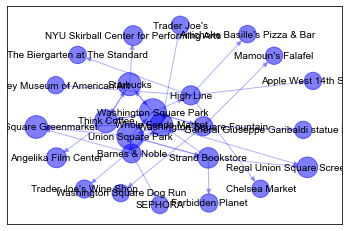

In [20]:
# Plot network

#fig = plt.figure(figsize(16,9), dpi=150)
nodesize = [10000 * n for n in pagerank.values()]
nx.draw_networkx_nodes(G, graph_pos, node_size=nodesize, alpha=.5, node_color='blue')
nx.draw_networkx_edges(G, graph_pos, width=1, alpha=.3, edge_color='blue')
nx.draw_networkx_labels(G, graph_pos, labels=labels, font_size=10, font_family='Arial')